In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'svg'
%matplotlib inline
import warnings

import torch

# only show 5 elements of a tensor
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=5)
torch.manual_seed(0)
warnings.filterwarnings("ignore")

!rm -rf lightning_logs

# PES Models

`graph-pes` aims to make getting set up with a new project as simple as possible. Below, we train a simple `LennardJones` for copper.

## 1: Data

`GraphPESModels` act on structures represented as `AtomicGraphs`. We expose several functions to make loading this data as simple as possible.

First, we load some chemical data. Here we use the wonderful [load-atoms](https://jla-gardner.github.io/load-atoms/) package to load a dataset of `ase.Atoms` objects:


In [2]:
from load_atoms import dataset

structures = dataset("Cu-POET")
structures

Please cite this dataset if you use it in your work.
For more information, visit:
https://jla-gardner.github.io/load-atoms/datasets/Cu-POET.html


Cu-POET:
    structures: 163
    atoms: 5,051
    species:
        Cu: 100.00%
    properties:
        per atom: (forces)
        per structure: (stress, energy, config_type)

We can see that this dataset has 163 structures, for a total of 5,051 atoms. Conveniently, we can see that the structures are labelled with per-structure energies (together with forces and stresses, which we will ignore for now).
Inspecting the first structure in this dataset gives:


In [3]:
structures[0]

Atoms(symbols='Cu8', pbc=True, cell=[2.5674848, 2.5674848, 25.41680279], forces=..., calculator=SinglePointCalculator(...))

Once we have a dataset of `ase.Atoms` objects, we can convert them to `AtomicGraphs` using the `convert_to_atomic_graphs` function. Using a cutoff of 5.0 Å, we can see that the first structure has 292 edges:


In [4]:
from graph_pes.data import convert_to_atomic_graphs

graphs = convert_to_atomic_graphs(structures, cutoff=5.0)
graphs[0]

AtomicGraph(Z=[8], positions=[8,3], neighbour_index=[2,292], forces=[8,3], energy=-28.79, stress=[3,3], device=cpu)

## 2: Model

Orthogonal to our data setup, we also need to define a model. Here we choose the simple `LennardJones` pair potential. Many others are available.


In [5]:
from graph_pes.models.pairwise import LennardJones

model = LennardJones()
model

LennardJones(
  (energy_summation): EnergySummation(
    local_transform=PerAtomShift(dim=(1,), requires_grad=True)
  )
  (epsilon): PositiveParameter(0.1000)
  (sigma): PositiveParameter(1.0000)
)

## 3: Training

Now we can train the model on our data. Since `GraphPESModel`'s are just normal `torch.nn.Module`'s, we can standard PyTorch training setups.

For convenience, `graph-pes` exposes a `train_model` function that takes care of much of the boilerplate, and uses `pytorch-lightning` under-the-hood to make the analysis of training runs easy.


In [6]:
import torch
from graph_pes.data import random_split
from graph_pes.loss import RMSE, Loss
from graph_pes.training import train_model
from graph_pes.transform import DividePerAtom

# define a train/val/test split
train, val, test = random_split(graphs, [120, 20, 23], seed=42)


def optimizer():
    # use a high learning rate for such a simple model
    return torch.optim.Adam(model.parameters(), lr=0.03)


train_model(
    model,
    train,
    val,
    optimizer,
    # only train the model on the energy property
    loss=Loss("energy", RMSE(), transform=DividePerAtom()),
    batch_size=32,
    # the arguments below are passed to the PyTorch Lightning Trainer:
    max_epochs=150,
    accelerator="cpu",
)

Training on : ['energy']
# of params : 3
Device      : CPU

Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 112.44it/s, v_num=0, val_energy_rmse=0.0224, val_energy_raw_rmse=0.538, val_total_loss=0.0224]

`Trainer.fit` stopped: `max_epochs=150` reached.


Epoch 149: 100%|██████████| 4/4 [00:00<00:00, 100.32it/s, v_num=0, val_energy_rmse=0.0224, val_energy_raw_rmse=0.538, val_total_loss=0.0224]


LennardJones(
  (energy_summation): EnergySummation(
    local_transform=PerAtomShift({
      Cu : [-2.677]
  }, dim=(1,), requires_grad=True)
  )
  (epsilon): PositiveParameter(0.1404)
  (sigma): PositiveParameter(2.2697)
)

## 4: Analysis

How did our model do? `graph-pes` exposes several useful functions for analysis:

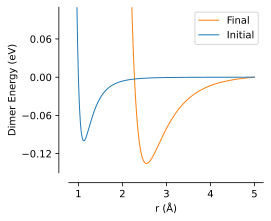

In [7]:
import matplotlib.pyplot as plt
from graph_pes.analysis import dimer_curve

# what we trained
dimer_curve(model, "Cu", units="eV", label="Final", c="C1")

# vs what we started with
_reference_model = LennardJones()
dimer_curve(_reference_model, "Cu", units="eV", label="Initial", c="C0")

plt.ylim(bottom=-0.15)
plt.legend(loc="upper right");

By default, `dimer-curve` zeros the energy at :code:`rmax`. We can also see that 
the model has learned a per-atom energy shift:

In [8]:
from ase import Atoms
from graph_pes.data import convert_to_atomic_graph

isolated = convert_to_atomic_graph(Atoms("Cu"), 1.0)

with torch.no_grad():
    print(f"Initial : {_reference_model(isolated).item():5.2f} eV")
    print(f"Final   : {model(isolated).item():5.2f} eV")

Initial :  0.00 eV
Final   : -2.68 eV


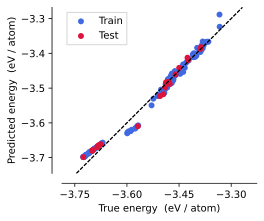

In [9]:
from graph_pes.analysis import parity_plot
from graph_pes.transform import DividePerAtom

for name, data, colour in zip(
    ["Train", "Test"],
    [train, test],
    ["royalblue", "crimson"],
):
    parity_plot(
        model,
        data,
        transform=DividePerAtom(),
        units="eV / atom",
        label=name,
        c=colour,
    )

plt.legend(fancybox=False, loc="upper left");

Since our model is fully differentiable, we can use the inbuilt `torch.autograd` machinery to compute forces as the negative gradient of the energy with respect to atomic positions.

In [10]:
structure = test[0]
structure._positions.requires_grad = True
energy = model(test[0])
forces = -torch.autograd.grad(energy, test[0]._positions)[0]
structure._positions.requires_grad = False

energy, forces.shape

(tensor(-117.6996, grad_fn=<SumBackward0>), torch.Size([32, 3]))

`graph-pes` makes this easy to do via the `GraphPESModel.predict` function:

In [11]:

# get predictions for all of the test set, using torch.autograd 
# internally to get the forces and stresses
predictions = model.predict(test)
{key: value.shape for key, value in predictions.items()}

{'energy': torch.Size([23]),
 'forces': torch.Size([714, 3]),
 'stress': torch.Size([23, 3, 3])}

Despite only training on energies, we can test on force errors:

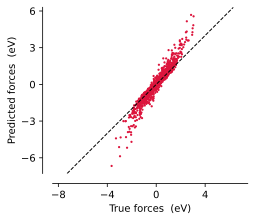

In [12]:
parity_plot(model, test, property="forces", units="eV", c="crimson", s=5)

And that's a wrap! We've trained a simple model on a simple dataset. See other examples for more advanced use-cases.
